# Working with the lyrics Bag of Word

In [55]:
import sqlite3
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [2]:
con_mxm = sqlite3.connect('mxm_dataset.db')
cur_mxm = con_mxm.cursor()

# displaying the different table available
tables = con_mxm.execute("SELECT name FROM sqlite_master WHERE type='table'")
table_names = tables.fetchall()

print('Tables within the database :')
print('{}'.format(table_names[0][0]))
print('{}'.format(table_names[1][0]))

Tables within the database :
words
lyrics


In [3]:
# import the "words" table in a pandas DataFrame
words = pd.read_sql_query("SELECT * FROM words",con_mxm)
print(words.info())
words.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
word    5000 non-null object
dtypes: object(1)
memory usage: 39.1+ KB
None


,word
0,i
1,the
2,you
3,to
4,and


In [4]:
# import the "lyrics" table in a pandas DataFrame
# limit to 10055 to have the exact content of each song (120 songs)
lyrics = pd.read_sql_query("SELECT *\
                           FROM lyrics\
                           ORDER BY track_id ASC",con_mxm)
lyrics = lyrics.to_sparse(fill_value=0)

print(lyrics.info())
lyrics.head(5)

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 19045332 entries, 0 to 19045331
Data columns (total 5 columns):
track_id    object
mxm_tid     int64
word        object
count       int64
is_test     int64
dtypes: int64(3), object(2)
memory usage: 598.0+ MB
None


,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0
1,TRAAAAV128F421A322,4623710,the,4,0
2,TRAAAAV128F421A322,4623710,you,2,0
3,TRAAAAV128F421A322,4623710,to,2,0
4,TRAAAAV128F421A322,4623710,and,5,0


## Removing stopwords

In [5]:
stp_wds = stopwords.words()

In [ ]:
words_no_stopwords = words[~np.isin(words.word, stp_wds)]
words_no_stopwords.head(5)

In [ ]:
lyrics_nostp = lyrics[~np.isin(lyrics.word, stp_wds)]
print(lyrics_nostp.info())

## Selecting only the Lyrics from the 10K Subset without stopwords

In [6]:
lyrics_10Ksubset = np.loadtxt('subset_unique_tracks.txt',
                              delimiter=b'<SEP>', usecols=0, dtype = ('S20'))

In [7]:
lyrics_sub = lyrics[lyrics['track_id'].isin(lyrics_10Ksubset.astype('str'))]
lyrics_sub = lyrics_sub[~np.isin(lyrics_sub.word, stp_wds)]

In [8]:
lyrics_sub.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Int64Index: 123201 entries, 87 to 997017
Data columns (total 5 columns):
track_id    123201 non-null object
mxm_tid     123201 non-null int64
word        123201 non-null object
count       123201 non-null int64
is_test     123201 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


In [9]:
len(lyrics_sub.track_id.unique())

2347

## Function to choose a given number of songs

In [ ]:
from sklearn.utils import shuffle

def get_n_songs(lyrics_df, n_songs=1 ,random=False):
    
    track_ids = lyrics.track_id.unique()
    
    if n_songs > len(track_ids):
        print('n_songs greater than the number of tracks ({}) ...'.format(len(track_ids)))
        print('... return the whole dataset')
        return lyrics_df
    
    if random == True :
        track_to_keep = np.random.choice(track_ids, n_songs, replace=False)
    elif random == False :
        track_to_keep = track_ids[:n_songs]

    lyrics_subset = lyrics_df[lyrics_df['track_id'].isin(track_to_keep)]
    
    return lyrics_subset

In [ ]:
lyrics_subtest = get_n_songs(lyrics, n_songs=100, random=True)

In [ ]:
lyrics_subtest.head(5)

## Function to pivot by chunks

Take into consideration sparsity

In [11]:
def pivot_by_chunks(lyrics_df, n_chunks=3, sparse=True):
    
    print('Processing chunk number 0')
    track_list = np.array_split(lyrics_df.track_id.unique(), n_chunks)
    df0 = lyrics_df[lyrics_df['track_id'].isin(track_list[0])]
    pivot_df = df0.pivot_table(index='track_id', columns=words, values='count', fill_value=0)
    del df0
    pivot_df = pivot_df.to_sparse(fill_value=0)

    for i in range(1, n_chunks):
        print('Processing chunk number {}'.format(i))
        df_tmp = lyrics_df[lyrics_df['track_id'].isin(track_list[i])]
        pivot_df_tmp = df_tmp.pivot_table(index='track_id', columns=words, values='count', fill_value=0)
        pivot_df = pivot_df.append(pivot_df_tmp).fillna(0)
        del df_tmp
        pivot_df = pivot_df.to_sparse(fill_value=0)

    return pivot_df

In [12]:
test_df = pivot_by_chunks(lyrics_df=lyrics_sub, n_chunks=10)

Processing chunk number 0
Processing chunk number 1
Processing chunk number 2
Processing chunk number 3
Processing chunk number 4
Processing chunk number 5
Processing chunk number 6
Processing chunk number 7
Processing chunk number 8
Processing chunk number 9


In [13]:
print(test_df.info())

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Index: 2347 entries, TRAAABD128F429CF47 to TRBIJYB128F14AE326
Columns: 4259 entries, & to ‘caus
dtypes: float64(3292), int64(967)
memory usage: 3.6+ MB
None


## Projections

Using some dimensionality reduction

### PCA

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
pca = PCA(n_components=2)
lyrics_no_pca = pca.fit_transform(test_df)

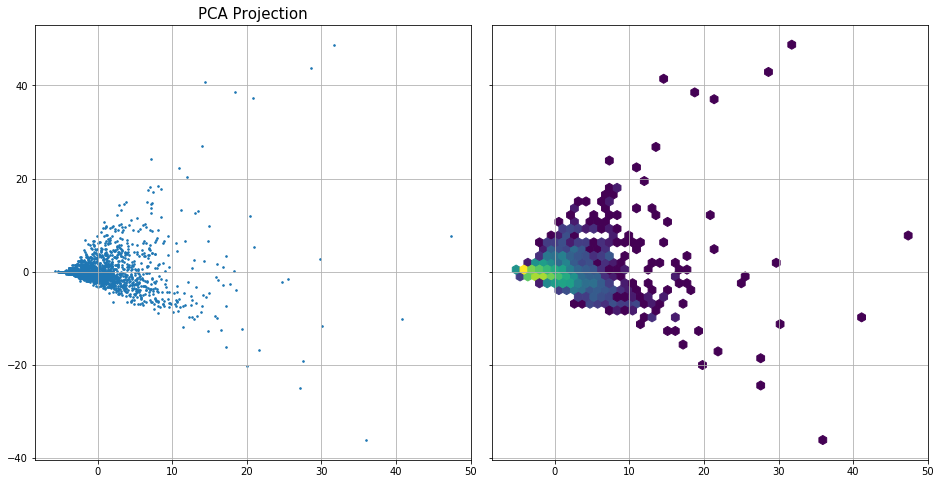

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

ax[0].scatter(lyrics_no_pca[:,0], lyrics_no_pca[:,1], marker='.', s=10)
ax[0].grid('on');
ax[0].set_title('PCA Projection', fontsize=15)

ax[1].hexbin(lyrics_no_pca[:,0], lyrics_no_pca[:,1], gridsize=51, mincnt=1,  bins='log')
ax[1].grid('on')
plt.subplots_adjust(wspace=0.05)
plt.savefig('PCA_projection.png');

### Isomap

In [17]:
from sklearn.manifold import Isomap

In [18]:
iso = Isomap(n_components=2)
lyrics_no_iso = iso.fit_transform(test_df)

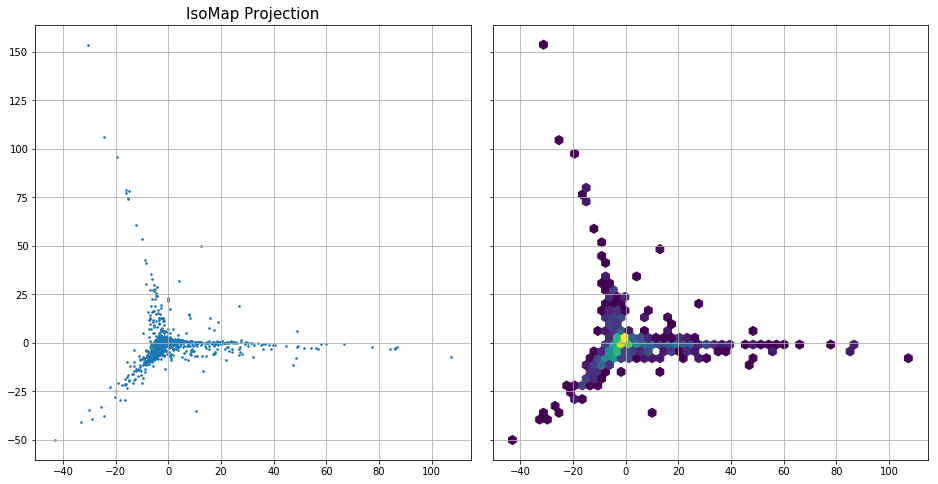

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

ax[0].scatter(lyrics_no_iso[:,0], lyrics_no_iso[:,1], marker='.', s=10)
ax[0].grid('on');
ax[0].set_title('IsoMap Projection', fontsize=15)

ax[1].hexbin(lyrics_no_iso[:,0], lyrics_no_iso[:,1], gridsize=51, mincnt=1,  bins='log')
ax[1].grid('on')
plt.subplots_adjust(wspace=0.05)
plt.savefig('IsoMap_projection.png');

### LLE

In [20]:
from sklearn.manifold import LocallyLinearEmbedding

In [21]:
lle = LocallyLinearEmbedding(n_components=2)
lyrics_no_lle = lle.fit_transform(test_df)

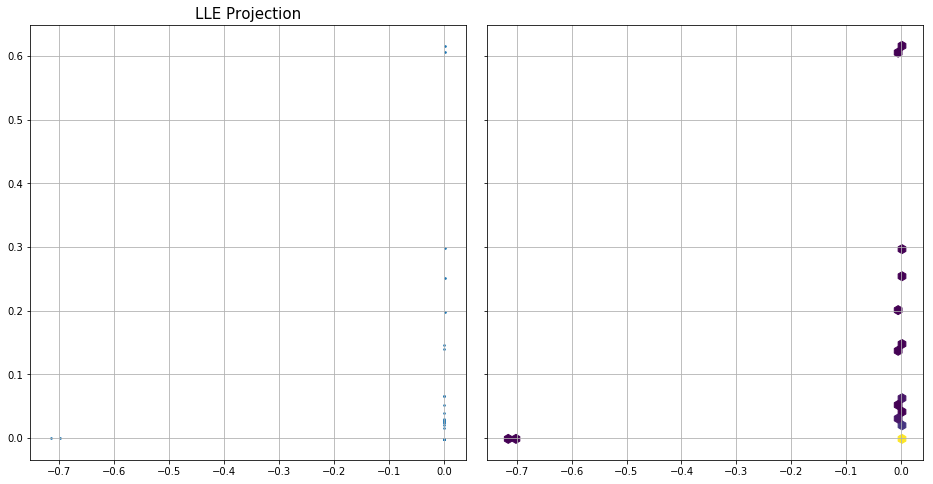

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

ax[0].scatter(lyrics_no_lle[:,0], lyrics_no_lle[:,1], marker='.', s=10)
ax[0].grid('on');
ax[0].set_title('LLE Projection', fontsize=15)

ax[1].hexbin(lyrics_no_lle[:,0], lyrics_no_lle[:,1], gridsize=51, mincnt=1,  bins='log')
ax[1].grid('on')
plt.subplots_adjust(wspace=0.05)
plt.savefig('LLE_projection.png');

### TSNE

In [23]:
from sklearn.manifold import TSNE

In [24]:
tsne = TSNE(n_components=2)
lyrics_no_tsne = tsne.fit_transform(test_df)

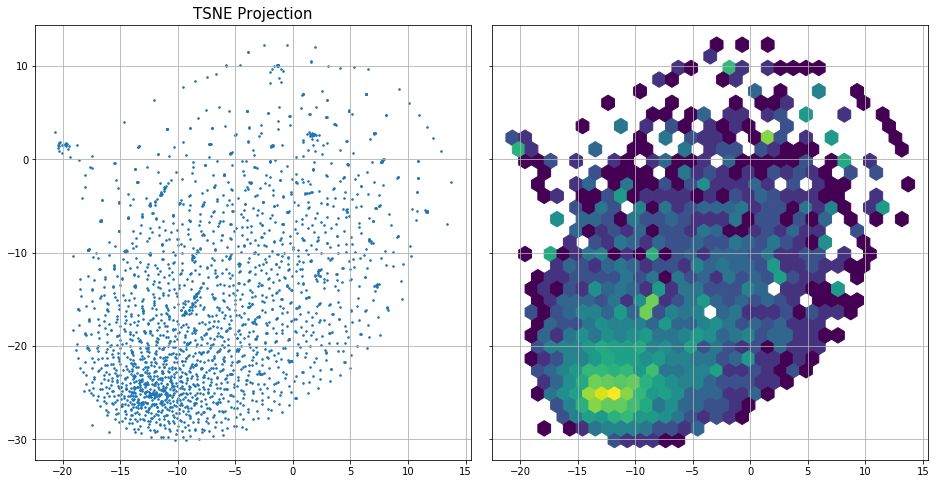

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

ax[0].scatter(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1], marker='.', s=10)
ax[0].grid('on');
ax[0].set_title('TSNE Projection', fontsize=15)

ax[1].hexbin(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1], gridsize=31, mincnt=1,  bins='log')
ax[1].grid('on')
plt.subplots_adjust(wspace=0.05)
plt.savefig('TSNE_projection.png');

## MDS

In [26]:
from sklearn.manifold import MDS

In [27]:
mds = MDS(n_components=2)
lyrics_no_mds = mds.fit_transform(test_df)

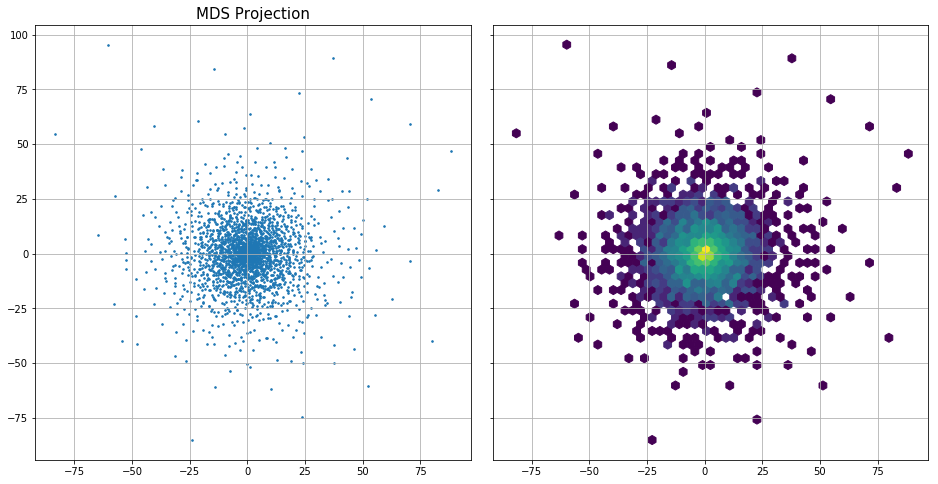

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True, sharey=True)

ax[0].scatter(lyrics_no_mds[:,0], lyrics_no_mds[:,1], marker='.', s=10)
ax[0].grid('on');
ax[0].set_title('MDS Projection', fontsize=15)

ax[1].hexbin(lyrics_no_mds[:,0], lyrics_no_mds[:,1], gridsize=51, mincnt=1,  bins='log')
ax[1].grid('on')
plt.subplots_adjust(wspace=0.05)
plt.savefig('MDS_projection.png');

## Clustering

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
agg = AgglomerativeClustering(n_clusters=10)
agg_preds = agg.fit_predict(test_df)

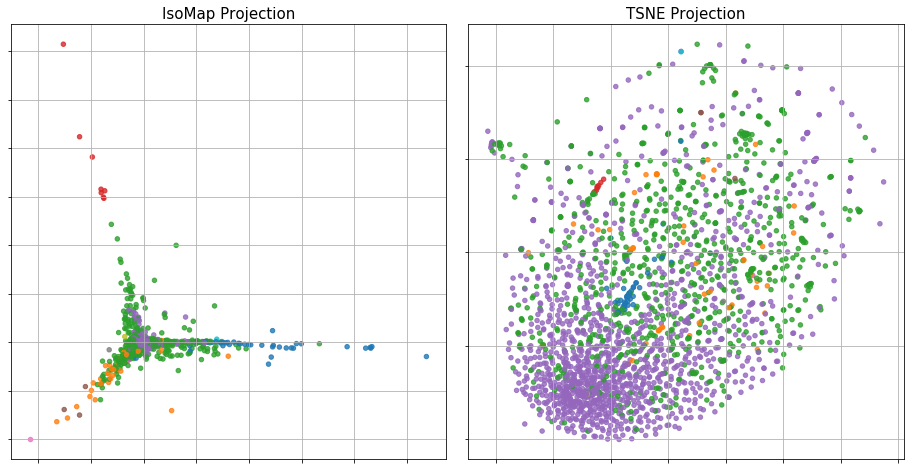

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].scatter(lyrics_no_iso[:,0], lyrics_no_iso[:,1],
              marker='o', s=20, c=agg_preds, cmap='tab10', alpha=0.8)
ax[0].grid('on');
ax[0].set_title('IsoMap Projection', fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].scatter(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1],
              marker='o', s=20, c=agg_preds, cmap='tab10', alpha=0.8)
ax[1].grid('on')
ax[1].set_title('TSNE Projection', fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
plt.savefig('Agglomerative_clustering.png');

In [45]:
from sklearn.cluster import AffinityPropagation

In [46]:
afp = AffinityPropagation(damping=0.96)
afp_preds = afp.fit_predict(test_df)

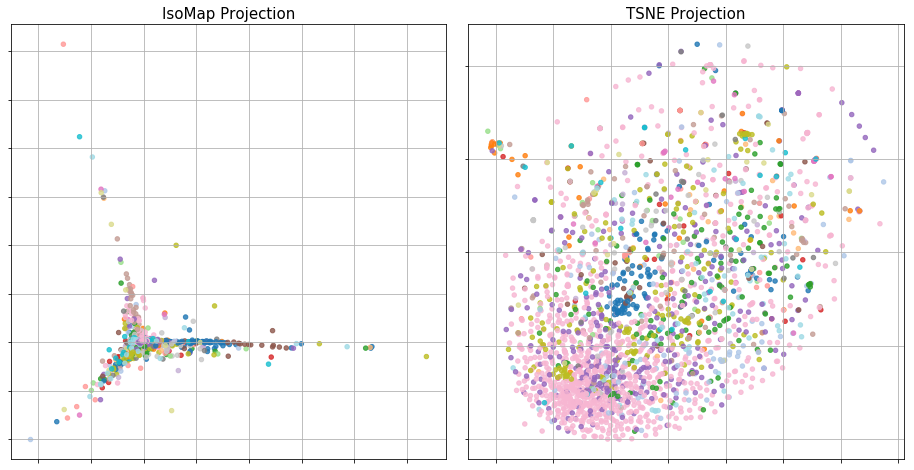

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].scatter(lyrics_no_iso[:,0], lyrics_no_iso[:,1],
              marker='o', s=20, c=afp_preds, cmap='tab20', alpha=0.8)
ax[0].grid('on');
ax[0].set_title('IsoMap Projection', fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].scatter(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1],
              marker='o', s=20, c=afp_preds, cmap='tab20', alpha=0.8)
ax[1].grid('on')
ax[1].set_title('TSNE Projection', fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
plt.savefig('Affinity_clustering.png');

In [32]:
from sklearn.mixture import BayesianGaussianMixture

In [33]:
gmm20 = BayesianGaussianMixture(n_components=20, covariance_type='full')
gmm20.fit(test_df)
gmm20_preds = gmm20.predict(test_df)

In [37]:
gmm10 = BayesianGaussianMixture(n_components=10, covariance_type='full')
gmm10.fit(test_df)
gmm10_preds = gmm10.predict(test_df)

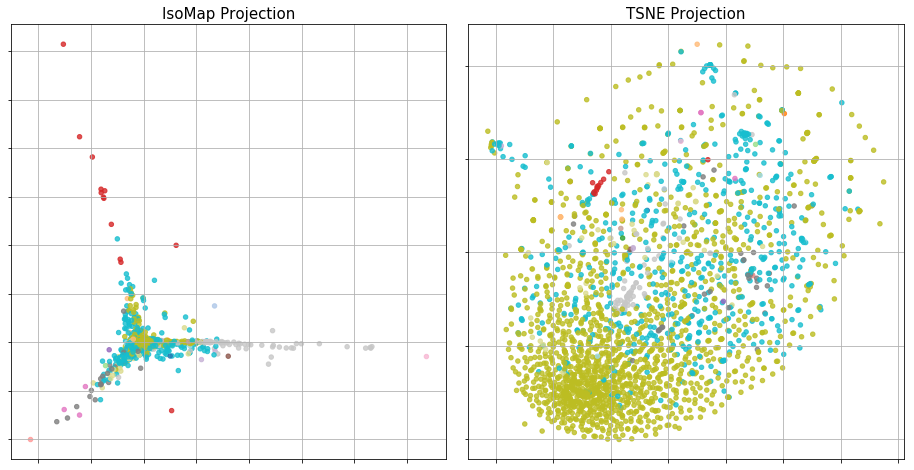

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].scatter(lyrics_no_iso[:,0], lyrics_no_iso[:,1],
              marker='o', s=20, c=gmm20_preds, cmap='tab20_r', alpha=0.8)
ax[0].grid('on');
ax[0].set_title('IsoMap Projection', fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].scatter(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1],
              marker='o', s=20, c=gmm20_preds, cmap='tab20_r', alpha=0.8)
ax[1].grid('on')
ax[1].set_title('TSNE Projection', fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
plt.savefig('GMM_20_clustering.png');

In [40]:
from sklearn.cluster import KMeans

In [41]:
kms = KMeans(n_clusters=10)
kms_preds = kms.fit_predict(test_df)

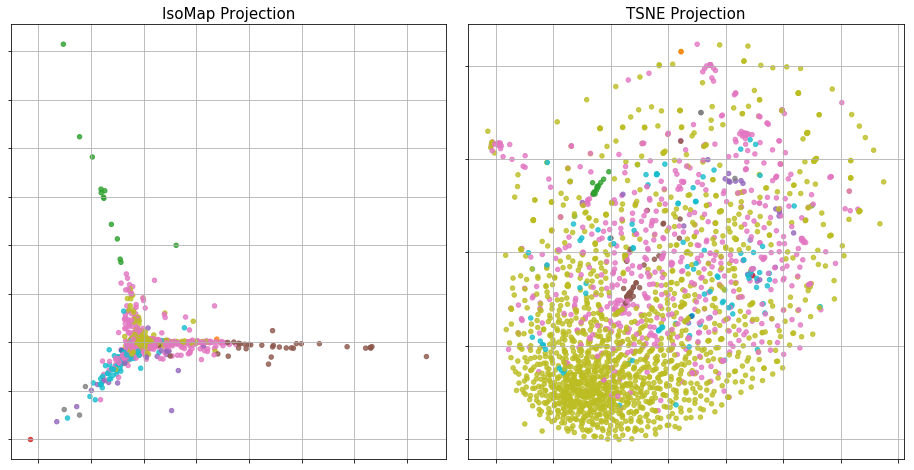

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax[0].scatter(lyrics_no_iso[:,0], lyrics_no_iso[:,1],
              marker='o', s=20, c=kms_preds, cmap='tab10_r', alpha=0.8)
ax[0].grid('on');
ax[0].set_title('IsoMap Projection', fontsize=15)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].scatter(lyrics_no_tsne[:,0], lyrics_no_tsne[:,1],
              marker='o', s=20, c=kms_preds, cmap='tab10_r', alpha=0.8)
ax[1].grid('on')
ax[1].set_title('TSNE Projection', fontsize=15)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
plt.savefig('KMeans_clustering.png');

## Saving Clustering Results

In [48]:
clustering_df = pd.DataFrame(index=test_df.index)

In [49]:
clustering_df['Affinity'] = afp_preds
clustering_df['Agglomerative'] = agg_preds
clustering_df['KMeans'] = kms_preds
clustering_df['GMM10'] = gmm10_preds
clustering_df['GMM20'] = gmm20_preds

In [50]:
clustering_df.to_csv('clustering_10Ksub.csv')

In [54]:
test_df.head(100)

,&,000,1,10,100,12,13,15,16,2,...,zwei,,¿qué,â,ça,é,être,ô,–,‘caus
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAABD128F429CF47,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAAAEF128F4273421,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAAAFD128F92F423A,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAAARJ128F9320760,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAABJV128F1460C49,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAABLR128F423B7E3,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAABVM128F92CA9DC,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAACER128F4290F96,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAACFV128F935E50B,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
